# Heart attack analysis

# Imports

In [61]:
try:
    import xgboost
except ModuleNotFoundError:
    !pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 10.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 27.5 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.1
    Uninstalling numpy-1.23.1:
      Successfully uninstalled numpy-1.23.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
habitat 0.2.2 requires imageio-ffmpeg>=0.2.0, which is not installed.
habitat 0.2.2 requires numpy-quaternion>=2019.3.18.14.33.20, which is not installed.
moviepy 2.0.0.dev2 requires imageio_ffmpeg>=0.2.0, which is not installed.
moviepy 2.0.0.dev2 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.1 which is incompatible.


In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data

In [46]:
df = pd.read_csv("./dataset/heart.csv")

In [47]:
df.shape

(303, 14)

In [48]:
df[:5]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


## Stats

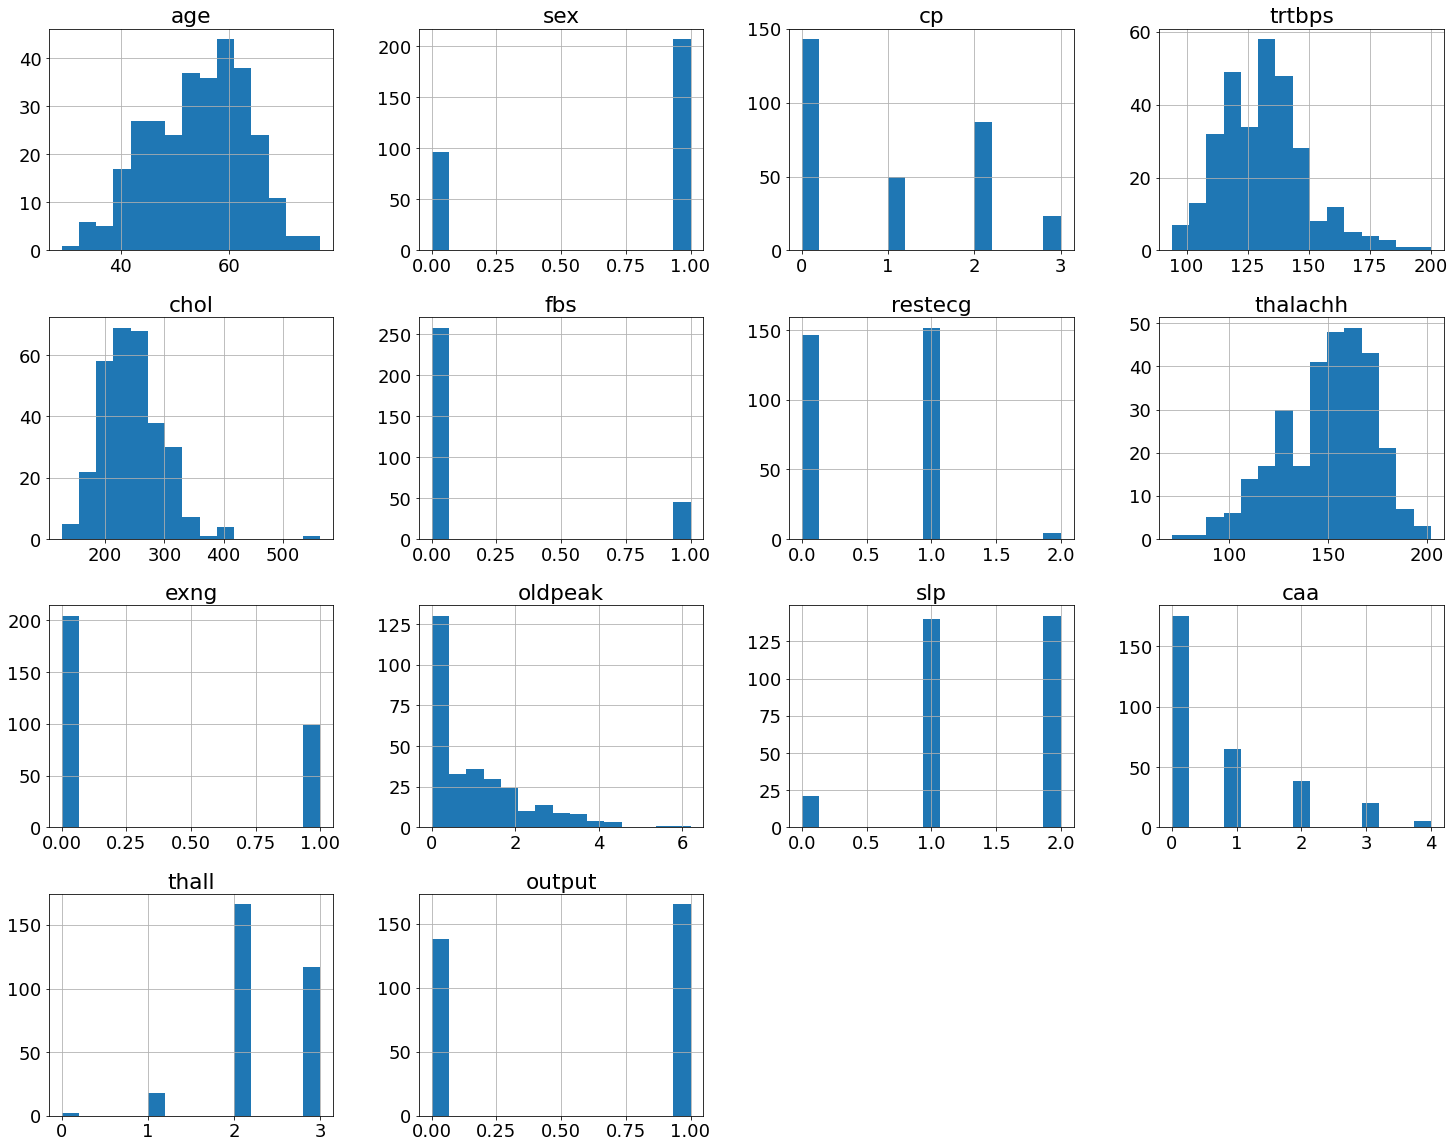

In [50]:
df.hist(bins=15,figsize=(25,20))
plt.show()

## Split

In [51]:
from sklearn.model_selection import StratifiedShuffleSplit

split=StratifiedShuffleSplit(n_splits=1,test_size=0.33,random_state=42)

for train_index, test_index in split.split(df, df['output']):
    strat_train_set=df.loc[train_index]
    strat_test_set=df.loc[test_index]

## Transforming the data

In [54]:
from sklearn.preprocessing import StandardScaler

def data_transformations(data):
    if 'output' in data.columns:
        labels=data['output']
        data=data.drop('output', axis=1)
    else:
        labels=None

    scaler=StandardScaler()
    data_scaled=scaler.fit_transform(data.select_dtypes(include=[np.number]))
    output=np.hstack([data_scaled,data.select_dtypes(exclude=[np.number])])

    return output, labels

In [55]:
train_data, train_labels = data_transformations(strat_train_set)
test_data, test_labels =data_transformations(strat_test_set)

In [56]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

In [57]:
def model_performance(cm):
    # Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print ("The True Positive rate / Recall per class is: ",TPR)


    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    print ("The Precision per class is: ",PPV)
    
    # False positive rate or False alarm rate
    FPR = FP/(FP+TN)
    print ("The False Alarm rate per class is: ",FPR)
    
    # False negative rate or Miss Rate
    FNR = FN/(TP+FN)
    print ("The Miss Rate rate per class is: ",FNR)
    
    
    # Classification error
    CER = (FP+FN)/(TP+FP+FN+TN)
    print ("The Classification error of each class is", CER)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print ("The Accuracy of each class is", ACC)
    print("")
    
    ##Total averages :
    print ("The average Recall is: ",TPR.sum()/2)
    print ("The average Precision is: ",PPV.sum()/2)
    print ("The average False Alarm is: ",FPR.sum()/2)
    print ("The average Miss Rate rate is: ",FNR.sum()/2)
    print ("The average Classification error is", CER.sum()/2)
    print ("The average Accuracy is", ACC.sum()/2)

# Model

In [84]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost

model = xgboost.XGBClassifier(tree_method='gpu_hist')
model.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

Confusion matrix, without normalization
[[41 13]
 [11 35]]


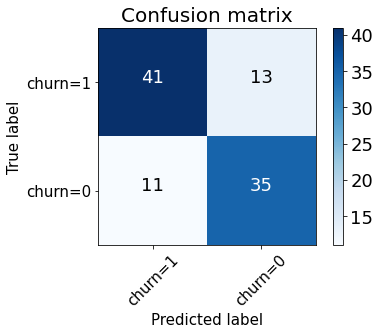

In [86]:
Y = model.predict(test_data)

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, Y, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_XG, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [87]:
model_performance(cnf_matrix)

The True Positive rate / Recall per class is:  [0.76 0.76]
The Precision per class is:  [0.79 0.73]
The False Alarm rate per class is:  [0.24 0.24]
The Miss Rate rate per class is:  [0.24 0.24]
The Classification error of each class is [0.24 0.24]
The Accuracy of each class is [0.76 0.76]

The average Recall is:  0.7600644122383253
The average Precision is:  0.7588141025641025
The average False Alarm is:  0.23993558776167473
The average Miss Rate rate is:  0.23993558776167473
The average Classification error is 0.24
The average Accuracy is 0.76


ROC AUC score is
0.8735909822866345


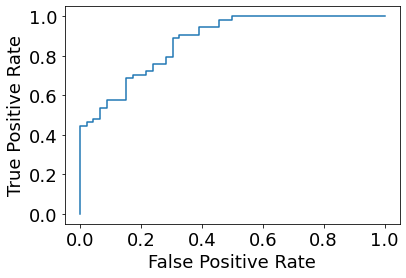

In [88]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics

y_pred_proba_xg = model.predict_proba(test_data)[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_labels,y_pred_proba_xg)
print('ROC AUC score is')
print(roc_auc_score(test_labels,y_pred_proba_xg))
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()